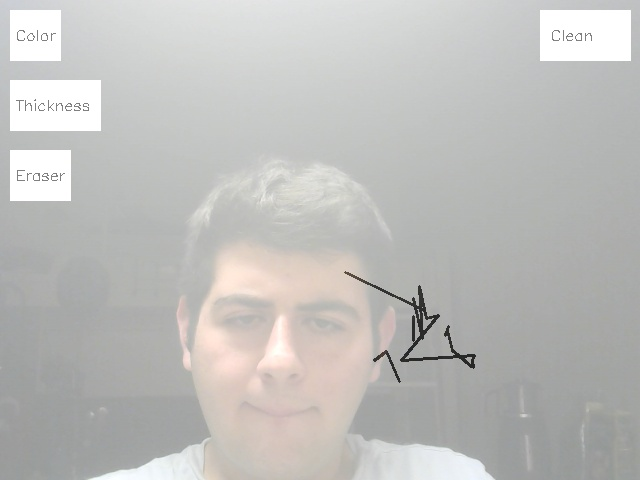

In [ ]:
import cv2
import mediapipe as mp
from IPython.display import display, clear_output
import PIL.Image
import io
import numpy as np

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_drawing = mp.solutions.drawing_utils
HAND_CONNECTIONS = mp_hands.HAND_CONNECTIONS

# Define button coordinates and size
color_button_coords = (10, 10, 60, 60)
thickness_button_coords = (10, 80, 100, 130)
eraser_button_coords = (10, 150, 70, 200)
clean_button_coords = (540, 10, 630, 60)  # Clean Board button

# Define color selection buttons
color_buttons = [
    ((70, 10, 130, 60), (0, 0, 255)),  # Red
    ((140, 10, 200, 60), (0, 255, 255)),  # Yellow
    ((210, 10, 270, 60), (0, 255, 0)),  # Green
    ((280, 10, 340, 60), (255, 0, 0)),  # Blue
    ((350, 10, 410, 60), (255, 255, 255)),  # White
    ((420, 10, 480, 60), (0, 0, 0))  # Black
]

# Define thickness selection buttons
thickness_buttons = [
    ((140, 80, 200, 130), 2),  # Thin
    ((210, 80, 270, 130), 5),  # Medium
    ((280, 80, 340, 130), 8),  # Thick
    ((350, 80, 410, 130), 12)  # Extra Thick
]

# Initialize drawing parameters
drawing_color = (0, 0, 255)
brush_thickness = 5
eraser_mode = False
drawing = False
last_point = None
color_picking_mode = False
thickness_picking_mode = False

# Create a blank canvas
canvas = np.ones((480, 640, 3), dtype=np.uint8) * 255

# Start webcam
cap = cv2.VideoCapture(0)

def is_point_in_rect(point, rect):
    x, y = point
    rx1, ry1, rx2, ry2 = rect
    return rx1 <= x <= rx2 and ry1 <= y <= ry2

def is_pointing_finger_up(hand_landmarks):
    index_tip = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP]
    index_mcp = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_MCP]
    return index_tip.y < index_mcp.y

def is_middle_finger_up(hand_landmarks):
    middle_tip = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP]
    middle_mcp = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_MCP]
    return middle_tip.y < middle_mcp.y

def is_thumb_outward(hand_landmarks):
    thumb_tip = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP]
    thumb_mcp = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC]
    return abs(thumb_tip.x - thumb_mcp.x) > 0.15  # Adjust the threshold as needed

def is_fist(hand_landmarks):
    for finger_tip in [mp_hands.HandLandmark.THUMB_TIP, mp_hands.HandLandmark.INDEX_FINGER_TIP,
                       mp_hands.HandLandmark.MIDDLE_FINGER_TIP, mp_hands.HandLandmark.RING_FINGER_TIP,
                       mp_hands.HandLandmark.PINKY_TIP]:
        tip = hand_landmarks.landmark[finger_tip]
        base = hand_landmarks.landmark[finger_tip - 2]  # Base joint of the finger
        if tip.y < base.y:
            return False
    return True

try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Flip the frame horizontally for a mirror effect
        frame = cv2.flip(frame, 1)

        # Convert the image to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process the frame and get hand landmarks
        result = hands.process(rgb_frame)

        # Draw buttons
        cv2.rectangle(frame, color_button_coords[:2], color_button_coords[2:], (255, 255, 255), -1)
        cv2.rectangle(frame, thickness_button_coords[:2], thickness_button_coords[2:], (255, 255, 255), -1)
        if eraser_mode:
            cv2.rectangle(frame, eraser_button_coords[:2], eraser_button_coords[2:], (0, 255, 255), -1)  # Highlight eraser button in cyan
        else:
            cv2.rectangle(frame, eraser_button_coords[:2], eraser_button_coords[2:], (255, 255, 255), -1)
        cv2.rectangle(frame, clean_button_coords[:2], clean_button_coords[2:], (255, 255, 255), -1)
        cv2.putText(frame, 'Color', (15, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        cv2.putText(frame, 'Thickness', (15, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        cv2.putText(frame, 'Eraser', (15, 180), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        cv2.putText(frame, 'Clean', (550, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

        if color_picking_mode:
            for coords, color in color_buttons:
                cv2.rectangle(frame, coords[:2], coords[2:], color, -1)

        if thickness_picking_mode:
            for coords, thickness in thickness_buttons:
                cv2.rectangle(frame, coords[:2], coords[2:], (200, 200, 200), -1)
                cv2.putText(frame, str(thickness), (coords[0] + 20, coords[1] + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

        # Draw hand landmarks if available
        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                mp_drawing.draw_landmarks(frame, hand_landmarks, HAND_CONNECTIONS)

                # Get the index finger tip coordinates
                index_tip = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP]
                index_tip_coords = (int(index_tip.x * frame.shape[1]), int(index_tip.y * frame.shape[0]))

                if is_pointing_finger_up(hand_landmarks):
                    if color_picking_mode:
                        for coords, color in color_buttons:
                            if is_point_in_rect(index_tip_coords, coords):
                                if is_thumb_outward(hand_landmarks):
                                    cv2.rectangle(frame, coords[:2], coords[2:], (0, 0, 255), -1)
                                    drawing_color = color
                                    color_picking_mode = False
                                    break
                                else:
                                    cv2.rectangle(frame, coords[:2], coords[2:], (100, 100, 255), -1)
                    elif thickness_picking_mode:
                        for coords, thickness in thickness_buttons:
                            if is_point_in_rect(index_tip_coords, coords):
                                if is_thumb_outward(hand_landmarks):
                                    cv2.rectangle(frame, coords[:2], coords[2:], (0, 0, 255), -1)
                                    brush_thickness = thickness
                                    thickness_picking_mode = False
                                    break
                                else:
                                    cv2.rectangle(frame, coords[:2], coords[2:], (100, 100, 255), -1)
                    else:
                        # Check if the index finger tip is pressing any button
                        if is_point_in_rect(index_tip_coords, color_button_coords):
                            if is_thumb_outward(hand_landmarks):
                                cv2.rectangle(frame, color_button_coords[:2], color_button_coords[2:], (0, 0, 255), -1)
                                color_picking_mode = True
                            else:
                                cv2.rectangle(frame, color_button_coords[:2], color_button_coords[2:], (100, 100, 255), -1)
                        elif is_point_in_rect(index_tip_coords, thickness_button_coords):
                            if is_thumb_outward(hand_landmarks):
                                cv2.rectangle(frame, thickness_button_coords[:2], thickness_button_coords[2:], (0, 0, 255), -1)
                                thickness_picking_mode = True
                            else:
                                cv2.rectangle(frame, thickness_button_coords[:2], thickness_button_coords[2:], (100, 100, 255), -1)
                        elif is_point_in_rect(index_tip_coords, eraser_button_coords):
                            if is_thumb_outward(hand_landmarks):
                                cv2.rectangle(frame, eraser_button_coords[:2], eraser_button_coords[2:], (0, 0, 255), -1)
                                eraser_mode = not eraser_mode  # Toggle eraser mode
                            else:
                                cv2.rectangle(frame, eraser_button_coords[:2], eraser_button_coords[2:], (100, 100, 255), -1)
                        elif is_point_in_rect(index_tip_coords, clean_button_coords):
                            if is_thumb_outward(hand_landmarks):
                                cv2.rectangle(frame, clean_button_coords[:2], clean_button_coords[2:], (0, 0, 255), -1)
                                canvas = np.ones((480, 640, 3), dtype=np.uint8) * 255  # Clear the canvas
                            else:
                                cv2.rectangle(frame, clean_button_coords[:2], clean_button_coords[2:], (100, 100, 255), -1)

                        # Draw on the canvas
                        if not is_point_in_rect(index_tip_coords, color_button_coords) and \
                           not is_point_in_rect(index_tip_coords, thickness_button_coords) and \
                           not is_point_in_rect(index_tip_coords, eraser_button_coords) and \
                           not is_point_in_rect(index_tip_coords, clean_button_coords):
                            if is_middle_finger_up(hand_landmarks):
                                if last_point is not None:
                                    if eraser_mode:
                                        cv2.line(canvas, last_point, index_tip_coords, (255, 255, 255), brush_thickness)
                                    else:
                                        cv2.line(canvas, last_point, index_tip_coords, drawing_color, brush_thickness)
                                last_point = index_tip_coords
                            else:
                                last_point = None
                elif is_fist(hand_landmarks):
                    last_point = None

        # Combine the canvas and the frame
        combined_frame = cv2.addWeighted(frame, 0.5, canvas, 0.5, 0)

        # Convert the frame to display in Jupyter Notebook
        _, buffer = cv2.imencode('.jpg', combined_frame)
        image = PIL.Image.open(io.BytesIO(buffer))
        
        # Display the frame
        clear_output(wait=True)
        display(image)

except KeyboardInterrupt:
    pass

cap.release()